In [1]:
from omegaconf import OmegaConf
import numpy as np
import os
import re
import os.path as osp
import torch
import pytorch_lightning as pl
from tqdm import tqdm
from omegaconf import OmegaConf
import wandb

import model_factory
from graph_data_module import GraphDataModule
from train import Runner
from datasets.dataset_factory import create_dataset
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import torchvision
import torchmetrics
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
run_id = "opfl4byn"
entity = "haraghi"
project = "DGCNN"
cfg_path = "cfg_folder"

In [3]:
method = "DGCNN"
dataset = "NASL"
sampling_number = "1024"

res = [f for f in os.listdir(cfg_path) if method in f and dataset in f and sampling_number in f]
for f in res:
    print(f)
pre_cfg_path = osp.join(cfg_path,res[0])

DGCNN_NASL_1024.yaml


In [4]:
api = wandb.Api()
if run_id is None:
    runs = api.runs(
        path=osp.join(entity,project),
        filters={"config.wandb.experiment_name": {"$regex": f"^.*{method}.*{sampling_nomber}.*$"}},
        # filters={"config.wandb.experiment_name": {"$regex": "^.*EST-aug 20000.*$"}}
    )
    print([l.id for l in runs])
    run_id = runs[0].id
    
print(run_id)

opfl4byn


In [5]:
run = wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: haraghi. Use `wandb login --relogin` to force relogin


In [6]:
checkpoint_reference = osp.join(entity, project, "model-" + run_id+":best")
artifact = run.use_artifact(checkpoint_reference, type='model')
artifact_dir = artifact.download()


config = api.run(osp.join(entity, project, run_id)).config
cfg = OmegaConf.create(config)

wandb:   1 of 1 files downloaded.  


In [7]:
cfg_file = OmegaConf.load(pre_cfg_path)
cfg = OmegaConf.merge(cfg_file, cfg)
print(OmegaConf.to_yaml(cfg))

description: ' Applying DGCNN2 on NASL with subsampling 1024. Does it also show good
  results? about 99 percent?'
seed: 0
optimize:
  optimizer: Adam
  lr: 0.001
  lr_scheduler: ReduceLROnPlateau
  mode: min
  factor: 0.5
  patience: 10
model:
  name: DGCNN2
  k: 50
  aggr: max
  num_bins: null
  resnet_crop_dimension: null
  est_mlp_layers: null
  est_activation: null
  resnet_pretrained: null
train:
  epochs: 100
  batch_size: 32
  loss_fn: nn.NLLLoss()
  profiler: simple
  ckpt_path: null
dataset:
  name: NASL
  train_percentage: 0.75
  validation_percentage: 0.1
  image_resolution:
  - 180
  - 240
  num_samples_per_class: null
  num_classes: 24
  dataset_path: null
  num_workers: 8
transform:
  train:
    transform: true
    spatial_centering: null
    temporal_scale: 1.0e-05
    num_events_per_sample: 1024
    random_flip: null
    scale_limits: null
    degree_limit: null
    thresh_quantile: null
    conv_vec_path: datasets/NCALTECH101/conv_scores
    radius_graph:
      transf

In [8]:
def percentile(t, q):
    B, C, H, W = t.shape
    k = 1 + round(.01 * float(q) * (C * H * W - 1))
    result = t.view(B, -1).kthvalue(k).values
    return result[:,None,None,None]

def create_image(representation):
    B, C, H, W = representation.shape
    representation = representation.view(B, 3, C // 3, H, W).sum(2)

    # do robust min max norm
    representation = representation.detach().cpu()
    robust_max_vals = percentile(representation, 99)
    robust_min_vals = percentile(representation, 1)

    representation = (representation - robust_min_vals)/(robust_max_vals - robust_min_vals)
    representation = torch.clamp(255*representation, 0, 255).byte()

    representation = torchvision.utils.make_grid(representation)

    return representation

In [9]:
# Seed everything. Note that this does not make training entirely
# deterministic.
pl.seed_everything(cfg.seed, workers=True)


# Create datasets using factory pattern
gdm = GraphDataModule(cfg)
cfg.dataset.num_classes = gdm.num_classes

Global seed set to 0


In [ ]:
# test_file_list = []
# for data in gdm.test_dataloader():
#     test_file_list.extend(data.file_id)

In [ ]:
# train_file_list = []
# for data in gdm.train_dataloader():
#     train_file_list.extend(data.file_id)

In [ ]:
# val_file_list = []
# for data in gdm.val_dataloader():
#     val_file_list.extend(data.file_id)

In [ ]:
# print(len(train_file_list))
# print(len(test_file_list))
# print(len(val_file_list))

In [ ]:
# print(set(test_file_list).intersection(set(val_file_list)))
# print(set(test_file_list).intersection(set(train_file_list)))
# print(set(val_file_list).intersection(set(train_file_list)))

In [10]:
model = model_factory.factory(cfg)

# Tie it all together with PyTorch Lightning: Runner contains the model,
# optimizer, loss function and metrics; Trainer executes the
# training/validation loops and model checkpointing.
 
runner = Runner.load_from_checkpoint(osp.join(artifact_dir,"model.ckpt"), cfg=cfg, model=model)

/home/hesam/miniconda3/lib/python3.10/site-packages/torch_geometric/nn/models/mlp.py:98: UserWarning: Argument `batch_norm` is deprecated, please use `norm` to specify normalization layer.
  warnings.warn("Argument `batch_norm` is deprecated, "


In [11]:
trainer = pl.Trainer(
    max_epochs=cfg.train.epochs,
    enable_progress_bar=True,
    # Use DDP training by default, even for CPU training
    # strategy="ddp_notebook",
    devices=torch.cuda.device_count(),
    accelerator="auto"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/hesam/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [12]:
trainer.test(runner, datamodule=gdm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 473/473 [04:33<00:00,  1.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9937169551849365
        test/loss          0.025945402681827545
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 0.025945402681827545, 'test/acc': 0.9937169551849365}]

In [13]:
dl = DataLoader(
            create_dataset(
                dataset_path = gdm.dataset_path,
                dataset_name  = gdm.dataset_name,
                dataset_type = 'test',
                transform = gdm.transform_dict['test'],
                num_workers=gdm.num_workers
            ),
            batch_size=16,
            shuffle=False,
            num_workers=gdm.num_workers,
        )
ds = create_dataset(
        dataset_path = gdm.dataset_path,
        dataset_name  = gdm.dataset_name,
        dataset_type = 'test',
        transform = gdm.transform_dict['test'],
        num_workers=gdm.num_workers
    )

In [36]:
(ds[0].batch is None)

True

In [22]:
torch.cuda.empty_cache()
confusion_matrix = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=cfg.dataset.num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = runner.model.to(device)
model.eval()

correct = 0
total = 0

y=torch.tensor([],device=device)
y_hat=torch.tensor([],device=device)
preds = []
targets = []
files = []
with torch.no_grad():
    for data in tqdm(gdm.test_dataloader()):
        files.extend(data.file_id)
        targets.append(data.y)
        data = data.to(device)
        y = torch.cat((y,data.y))
        out = model(data)
        preds.append(out.clone().detach().cpu())
        label = torch.argmax(out, dim=1) 
        y_hat = torch.cat((y_hat,label))
        correct += torch.sum(label == data.y)
        total += data.y.shape[0]
print(correct/total)   
y = y.clone().detach().cpu().numpy()
y_hat = y_hat.clone().detach().cpu().numpy() 

100%|██████████| 473/473 [04:34<00:00,  1.73it/s]

tensor(0.9943, device='cuda:0')


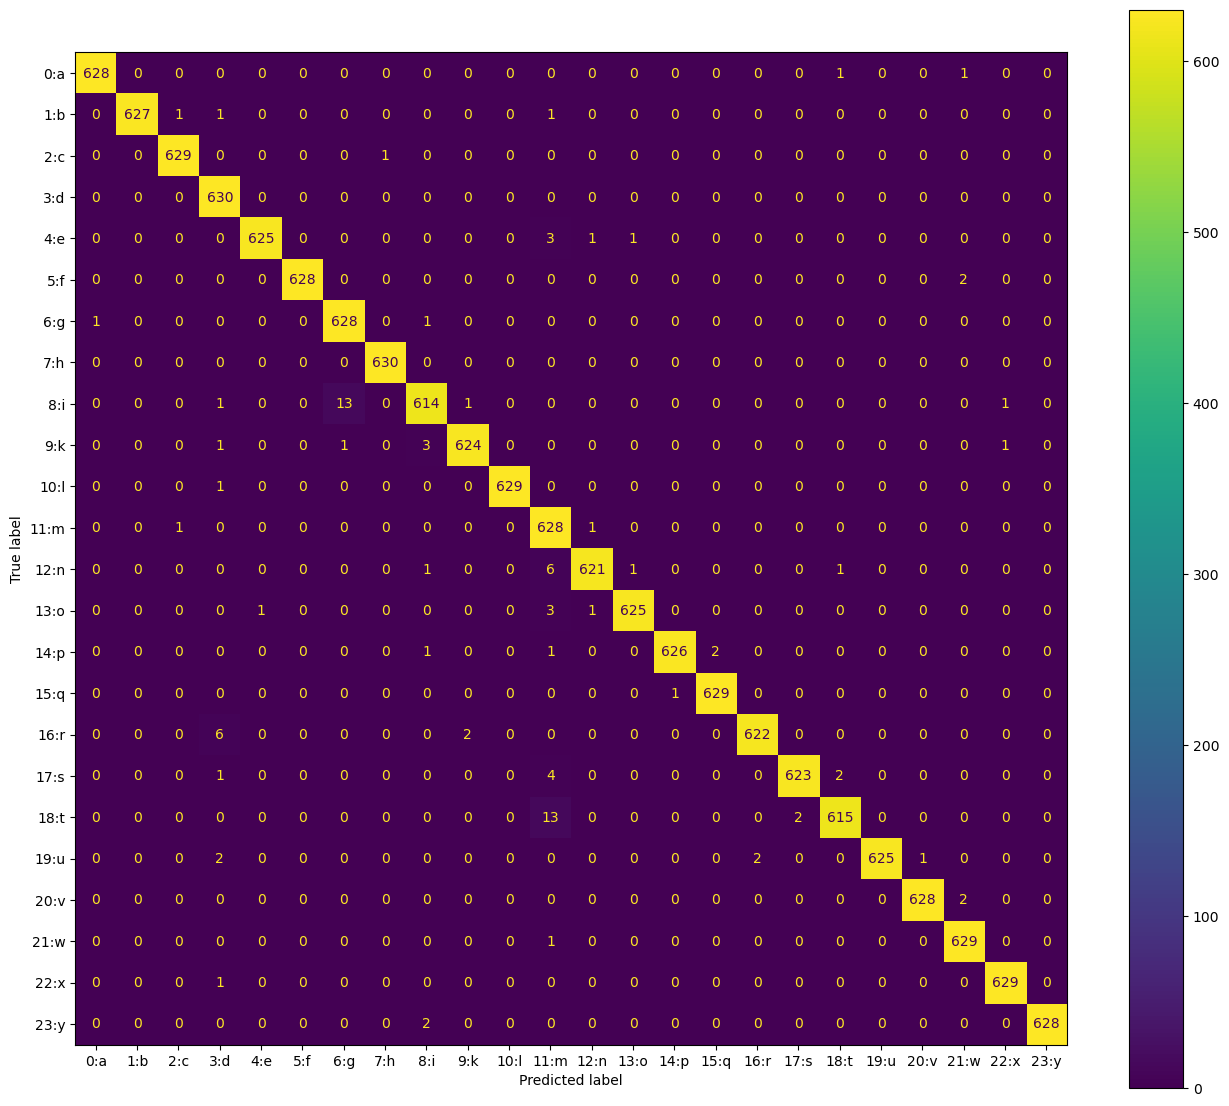

In [15]:
preds_ = torch.cat(preds,dim=0) #.permute(0,2,1)
targets_ = torch.cat(targets,dim=0)
metrics = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=cfg.dataset.num_classes) 
metrics.update(preds_, targets_)
confusion_matrix_computed = metrics.compute().detach().cpu().numpy().astype(int)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_computed, display_labels = [f'{i}:{c}' for i,c in enumerate(ds.categories)])
fig, axs = plt.subplots(1, 1, figsize=(16,14))
disp.plot(ax=axs)
plt.show()

In [16]:
off_zero = confusion_matrix_computed - np.diag(np.diag(confusion_matrix_computed))
gg =  np.unravel_index(np.argsort(off_zero, axis=None), off_zero.shape)
for i in range(1, 20):
    print(f'The {i}th largest off-diagonal element is {off_zero[gg[0][-i], gg[1][-i]]} at ({gg[0][-i]}:{ds.categories[gg[0][-i]]} -> {gg[1][-i]}:{ds.categories[gg[1][-i]]})')

The 1th largest off-diagonal element is 13 at (8:i -> 6:g)
The 2th largest off-diagonal element is 13 at (18:t -> 11:m)
The 3th largest off-diagonal element is 6 at (16:r -> 3:d)
The 4th largest off-diagonal element is 6 at (12:n -> 11:m)
The 5th largest off-diagonal element is 4 at (17:s -> 11:m)
The 6th largest off-diagonal element is 3 at (13:o -> 11:m)
The 7th largest off-diagonal element is 3 at (9:k -> 8:i)
The 8th largest off-diagonal element is 3 at (4:e -> 11:m)
The 9th largest off-diagonal element is 2 at (17:s -> 18:t)
The 10th largest off-diagonal element is 2 at (19:u -> 16:r)
The 11th largest off-diagonal element is 2 at (18:t -> 17:s)
The 12th largest off-diagonal element is 2 at (16:r -> 9:k)
The 13th largest off-diagonal element is 2 at (23:y -> 8:i)
The 14th largest off-diagonal element is 2 at (14:p -> 15:q)
The 15th largest off-diagonal element is 2 at (20:v -> 21:w)
The 16th largest off-diagonal element is 2 at (19:u -> 3:d)
The 17th largest off-diagonal element is

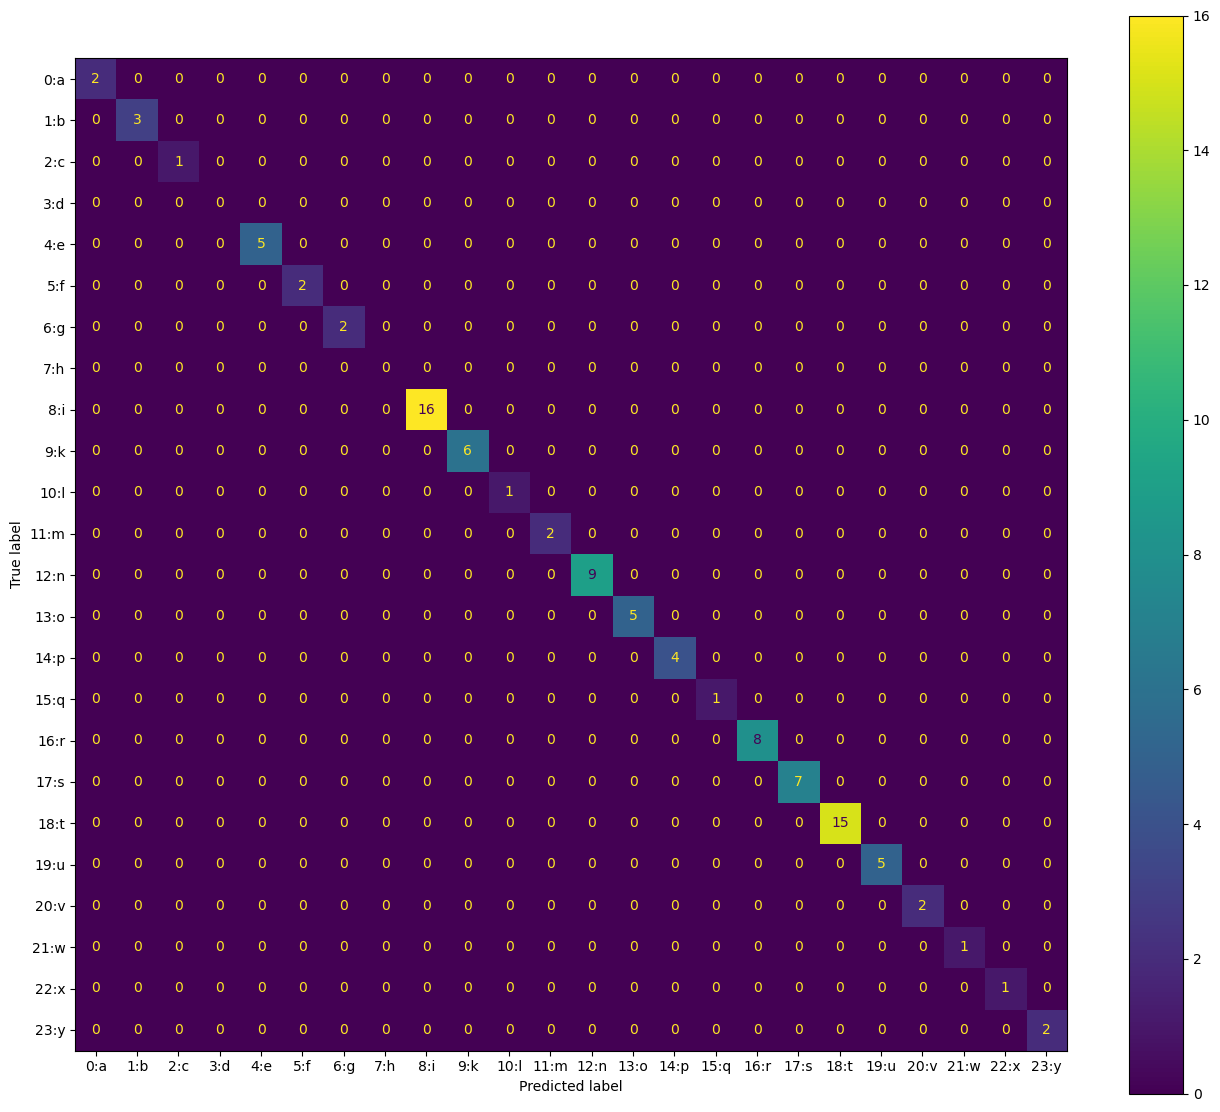

In [25]:
err_mat = np.diag(np.sum(off_zero,axis=1)) #+ np.diag(np.sum(off_zero,axis=0)) 
disp = ConfusionMatrixDisplay(confusion_matrix=err_mat, display_labels = [f'{i}:{c}' for i,c in enumerate(ds.categories)])
fig, axs = plt.subplots(1, 1, figsize=(16,14))
disp.plot(ax=axs)
plt.show()

In [18]:
for i in np.where((y == 18) & (y_hat == 11))[0]:
    print(i,ds[i].label,ds[i].file_id)

91 ['t'] t_0468.mat
137 ['t'] t_1293.mat
147 ['t'] t_3746.mat
235 ['t'] t_3883.mat
326 ['t'] t_0338.mat
350 ['t'] t_3954.mat
428 ['t'] t_3317.mat
431 ['t'] t_3045.mat
497 ['t'] t_4134.mat
526 ['t'] t_3704.mat
528 ['t'] t_3775.mat
601 ['t'] t_3374.mat
629 ['t'] t_1185.mat


In [19]:
name2ind = {d.file_id: i  for i, d in enumerate(ds)}

In [26]:
count = 0
for n,v in name2ind.items():
    if n.startswith('t_'):
        print(n, v)
        count += 1
        if count == 20:
            break

t_2540.mat 0
t_1511.mat 1
t_0390.mat 2
t_1161.mat 3
t_4130.mat 4
t_2291.mat 5
t_2136.mat 6
t_0961.mat 7
t_3969.mat 8
t_1403.mat 9
t_2211.mat 10
t_3705.mat 11
t_3839.mat 12
t_0465.mat 13
t_0190.mat 14
t_2028.mat 15
t_0950.mat 16
t_1186.mat 17
t_4142.mat 18
t_2174.mat 19


In [29]:
idx = torch.randint(0, len(ds),(1,))
idx = [19]
# idx = (name2ind['l_0011.mat'],)
correct = 0
total = 0

y1_hat = []
model.eval()

with torch.no_grad():
    for ii in tqdm(range(1000)):
        
        data = ds[idx][0]
        data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
        data = data.to(device)
        
        out = model(data)
        label = torch.argmax(out, dim=1)
        y1_hat.append(label.cpu().item())
        correct += torch.sum(label == data.y)
        total += data.y.shape[0]
    # loss = runner.loss_fn(y_hat, y)
print(data.file_id)    
print(correct/total)
print([ds.categories[int(c)] for c in np.unique(np.array(y1_hat))])

100%|██████████| 1000/1000 [00:52<00:00, 19.12it/s]

t_2174.mat
tensor(0.9910, device='cuda:0')
['m', 't']


In [97]:
np.where(np.array(y1_hat) !=  ds[idx][0].y.clone().detach().cpu().numpy())

(array([], dtype=int64),)

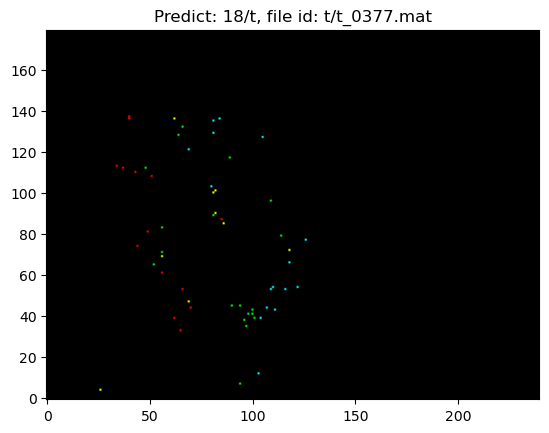

In [266]:

idx = 31
data = ds[idx]

fig, axs = plt.subplots(1, 1)
data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
data = data.to(device)
out = model(data)
vox = model.quantization_layer.forward(data)
label = torch.argmax(out, dim=1)
rep = create_image(vox)
axs.imshow(rep.permute(1,2,0))
axs.invert_yaxis()
axs.set_title(f"Predict: {label.item()}/{ds.categories[label.item()]}, file id: {data.label[0]}/{data.file_id}")
plt.show()

In [ ]:

ys = [d.y.clone().detach().item() for d in ds]
ys = np.array(ys)

# count the number of happening of each value in the numpy array
unique, counts = np.unique(ys, return_counts=True)

print(counts)
print(counts.sum())

In [ ]:
n = 1
m = 2
with torch.no_grad():
    for u in unique:
        fig, axs = plt.subplots(n, m, figsize=(m*8,n*6))
        if n == 1:
            axs = axs[None,...]
        if m == 1:
            axs = axs[...,None]
        print(u)

        for i in range(n):
            for j in range(m):
                
                indices = np.where(ys == u)[0]
                idx = np.random.choice(indices)
                
                data = ds[idx]
                
                data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
                data = data.to(device)
                out = model(data)
                vox = model.quantization_layer.forward(data)
                label = torch.argmax(out, dim=1)
                if label != u:
                    print("Wrong label")
                rep = create_image(vox)
                axs[i,j].imshow(rep.permute(1,2,0))
                # axs[i,j].invert_yaxis()
                axs[i,j].set_title(f"Predict: {label.item()}/{ds.categories[label.item()]}, file id: {data.label[0]}/{data.file_id}, idx: {idx}")

        plt.show()


In [ ]:
ds.categories[0]